In [1]:
import numpy as np
import json
import os
import torch

from utils.camera import *
from utils.equirectangular_render import *
from utils.eval_camera import *
from utils.eval_depth import *
from utils.eval_mesh import *
from utils.eval_normal import *
from utils.visualize import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
ply_path = '/home/jaxa/shintaro/OmniGauSS/Blender360/meshes/00200000.ply'
gt_ply_path = '/home/jaxa/takama/NeurIPS2025/NeurIPS_data-check/barbershop_interior_removed.ply'
img_idx = '00024'
camera_path = f'/home/jaxa/shintaro/Blender360/barbershop/Egocentric/cameras/{img_idx}_cam.json'
gt_depth_path = f'/home/jaxa/shintaro/Blender360/barbershop/Egocentric/depths/{img_idx}_depth0005.exr'        # BUG: depth を保存するときの名前を間違っている？ 最後の視点のデプスしか望んできていないかも      
gt_normal_path = f'/home/jaxa/shintaro/Blender360/barbershop/Egocentric/normals/{img_idx}_normal0005.exr'
gt_rgb_path = f'/home/jaxa/shintaro/Blender360/barbershop/Egocentric/images/{img_idx}_rgb.png'

with open(camera_path, 'r') as f:
    cameras = json.load(f)
camera_info = cameras[0]
extrinsics = camera_info["extrinsics"]
rotation = np.array(extrinsics["rotation"])
translation = np.array(extrinsics["translation"])
rotation = np.linalg.inv(rotation)
translation = -rotation @ np.array(translation)

## Visualize Rendered RGB, Depth, Normal from Mesh

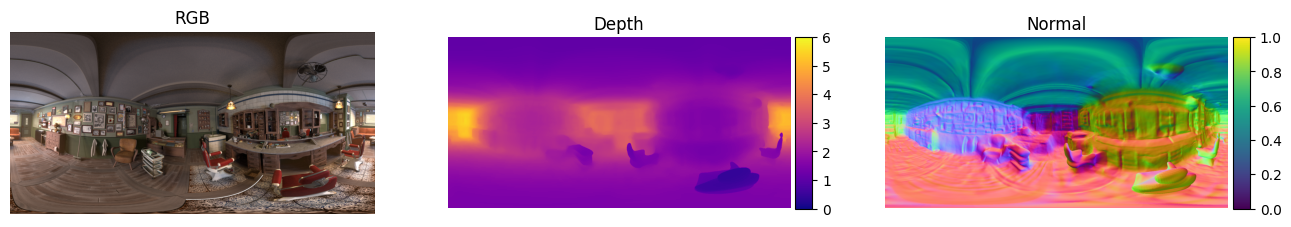

In [3]:
depth_map, normal_map = equirectangular_renderer_from_mesh(ply_path, width=1600, height=800, origin=translation, rotation=rotation)  # NOTE: scale を乗じていない

from PIL import Image
rgb = np.array(Image.open(gt_rgb_path))
visualize_rgb_depth_normal(rgb, depth_map, normal_map, visualize_depth_max=6.0)

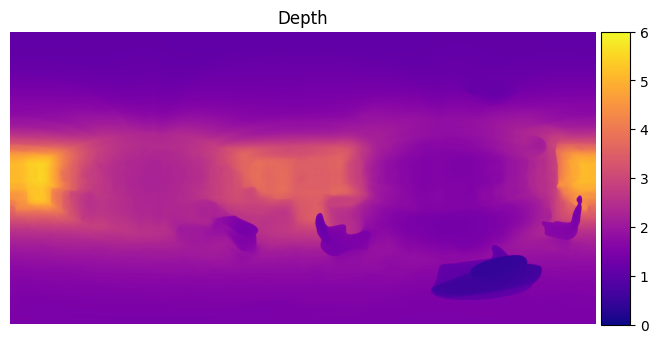

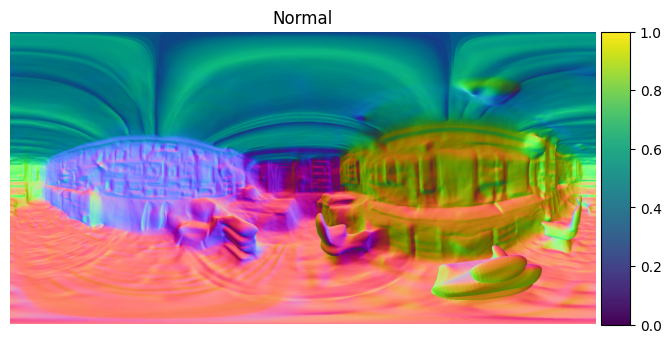

In [4]:
visualize_depth(depth_map=depth_map, visualize_depth_max=6.0)
visualize_normal(normal_map=normal_map)

## Depth Evaluation

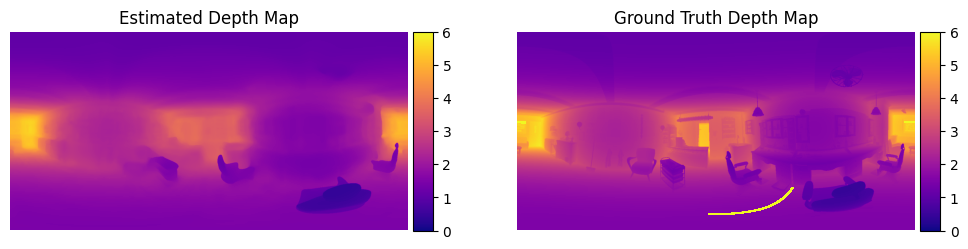

esitimated depth map 
 min: 0.4218389689922333, max: 5.527189254760742
ground truth depth map 
 min: 0.4570150077342987, max: 10000000000.0
{'RMSE': 0.21254331361177198, 'MAE': 0.10379839911048012, 'RMSE_scale_invariant': 0.09334250482122476, 'Percentage_within_threshold_1.25': 0.9680490525886217, 'MSE': 0.04517466016107205, 'RMSE_log': 0.09875698995104086, 'Abs_relative_difference': 0.05023772624982703, 'Squared_relative_difference': 0.018181335004929182}


In [5]:
depth_map_gt = np.array(read_exr_depth_v2(gt_depth_path)).astype(np.float32)
visualize_depth_comparison(depth_map, depth_map_gt, visualize_depth_max=6.0, description1="Estimated Depth Map", description2="Ground Truth Depth Map")

print(f"esitimated depth map \n min: {depth_map.min()}, max: {depth_map.max()}")
print(f"ground truth depth map \n min: {depth_map_gt.min()}, max: {depth_map_gt.max()}")
depth_metrics = calculate_metrics(depth_map, depth_map_gt, depth_max_value=20.0)
print(depth_metrics)

## Normal Evaluation

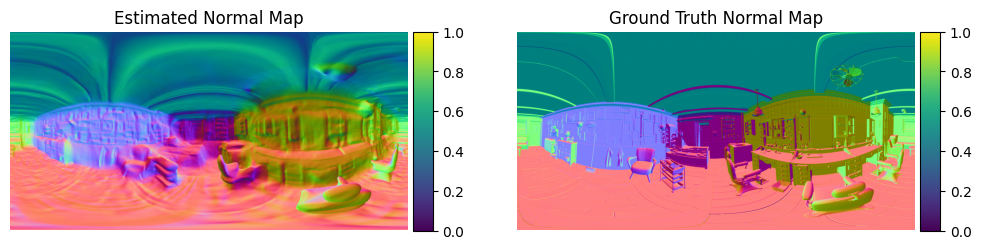

{'mean': 9.202894, 'median': 5.728476, 'rmse': 13.46781487473005, 'a5': 44.4528125, 'a7.5': 60.108046875, 'a11.25': 74.253046875, 'a22.5': 90.541796875, 'a30': 95.214296875}


In [6]:
normal_map_gt = np.array(read_exr_normal(gt_normal_path)).astype(np.float32)
visualize_normal_conparison(normal_map, normal_map_gt, description1="Estimated Normal Map", description2="Ground Truth Normal Map")

normal_metrics = compute_normal_metrics_from_numpy(normal_map, normal_map_gt)
print(normal_metrics)

## Mesh Evaluation

In [7]:
mesh_gt = trimesh.load(gt_ply_path, process=False)
mesh_reconstructed = trimesh.load(ply_path, process=False)
mesh_metrics = evaluate(mesh_reconstructed, mesh_gt, threshold=0.1)
print(mesh_metrics)

/home/jaxa/takama/envs/py38_torch211_cuda121/lib/python3.8/site-packages/trimesh/grouping.py:274: RuntimeWarning: invalid value encountered in cast
  return np.round((data * 10**digits) - 1e-6).astype(np.int64)


{'Acc': 0.115165469410536, 'Comp': 0.2013706020113857, 'CD': 0.15826803571096085, 'Prec@0.1': 0.5211725484417594, 'Recal@0.1': 0.45643854471892303, 'F-score@0.1': 0.48666231638005775, '# of points before downsampling (pred)': 1374377, '# of points before downsampling (gt)': 4944975, '# of points after downsampling (pred)': 325752, '# of points after downsampling (gt)': 191798}


## Save Metrics

In [8]:
all_metrics = {
    "depth_metrics": depth_metrics,
    "normal_metrics": normal_metrics,
    "mesh_metrics": mesh_metrics
}

# from float32 to float
for eval_target, metrics in all_metrics.items():
    for metric, value in metrics.items():
        if isinstance(value, np.float32):
            all_metrics[eval_target][metric] = float(value)

# save metrics to JSON file
output_path = "metrics.json"
with open(output_path, "w") as f:
    json.dump(all_metrics, f, indent=4)

print(f"Metrics saved to {output_path}")

Metrics saved to metrics.json
